### 6-14.프로젝트 : CIFAR-10 이미지 생성

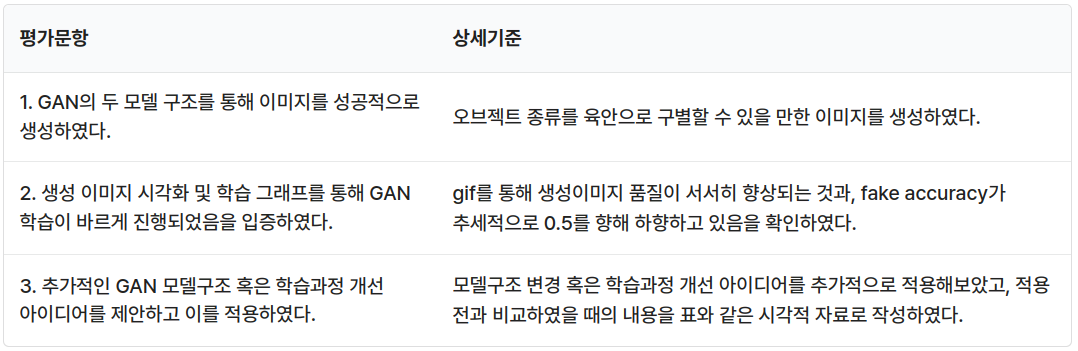

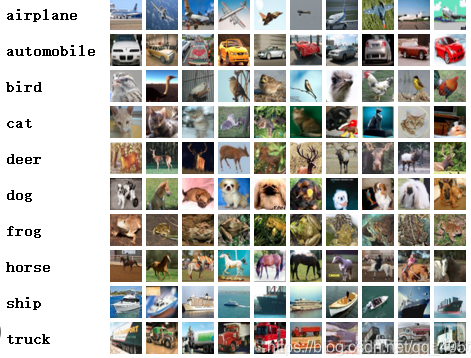


- GAN을 학습하는 과정은 까다롭다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할것 많다.




- 이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
  모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점.
  
  
  
  

- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있다.
  이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경. 시각화 과정에서 고려할 점이 있다.
  입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라짐.
  
  
  
  
  
- 라이브러리 버전 확인!

In [4]:
import os
import glob
import time
import PIL
import imageio
import tensorflow
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print(tensorflow.__version__)
print(imageio.__version__)

2.6.0
2.9.0


### STEP 1. 작업환경 구성하기

### STEP 2. 데이터셋 구성하기

 #### 1) CIFAR-10 가져오기 
 
 
 
 
 
 -   CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성

In [5]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

#### 2) 학습에 사용할 train_x의 이미지를 -1, 1로 정규화.

- 픽셀을 [0,1]이 아니라 [-1,1]로 정규화하는 이유?

  중간값을 0으로 맞춤
  
  생성자 모델 마지막 레이어에서 activation='tanh'를 사용함.  tanh와 모양을 맞추기 위함.
  
  [0,1]을 사용할 경우, 값을 절반밖에 사용하지 못하기 때문.

In [6]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [7]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


#### 2) 로드한 학습 데이터를 시각화를 통해 확인.


- 이미지 색깔 정상적으로 출력하는 방법
  train_x[0] 를 plt.imshow()로 출력하면 색깔이 파랗게 나옴
  Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  => 해결? train_x 를 앞에서 [-1,1] 범위로 정규화 했기 때문에 [0,1] 범위로 만들어서 출력하! => (train_x[0]+1)/2 값으로 plt.imshow()로 출력하면 
  정상적으로 나옴!
  plt.imshow() 에서 cmap 인자값을 주지 않음!



In [8]:
def de_normalize(train):
    return (127.5 * train) + 127.5

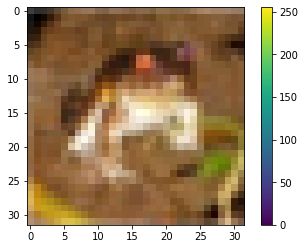

In [9]:
plt.imshow(de_normalize(train_x[0]).astype(np.int32).reshape(32, 32, 3))
plt.colorbar()
plt.show()

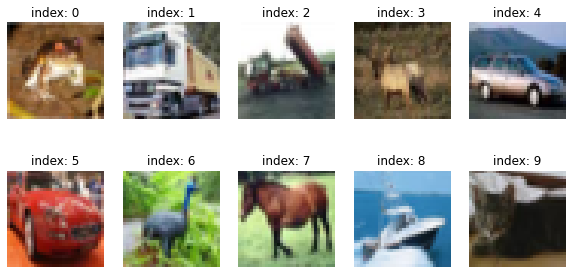

In [10]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(de_normalize(train_x[i]).astype(np.int32).reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

## 여기까지 전처리는 끝  !


#### 3) tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성 


- 모델에 넣어서 학습시키게 텐서플로우의 Dataset 준비. 이를 이용하면 우리가 매번 모델에게 직접 섞어서 넣어주지 않아도 됨.




- BUFFER_SIZE은 전체 데이터를 섞기 위해 60,000 설정. shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어줄것.

  텐서플로우 공식 문서: tf.data.Dataset
  
  
  
  
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다. 
  아래 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다. 
  데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정.





- BUFFER_SIZE
  전체 데이터를 섞기(shuffle() 함수 사용) 위함
  데이터가 잘 섞이려면 BUFFER_SIZE 를 총 데이터 사이즈와 같거나 크게 설정해야 좋다.
  동일한 50000으로 잘라 학습시킴. 
 

- BATCH_SIZE : 모델이 한 번에 학습할 데이터의 양 
  한번 학습을 하는데에도 오래 걸리므로 적절한 사이즈로 잘라. 즉 미니배치 학습. 
  
  
  
- tf.data.Dataset.from_tensor_slices(): 리스트, 넘파이, 텐서플로우의 텐서 자료형에서 데이터셋 생성




  
  

In [11]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### STEP 3. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성.



- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성.
  생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인.
  
- GAN에는 생성자, 판별자 모델 두 개.
  구현해 볼 모델은 이전 스텝에서 언급했던 DCGAN(Deep Convolutional GAN). DCGAN은 GAN의 개념이 처음 소개된 1년 반 이후 발표된 논문으로서, 
  이전의 GAN을 더욱 발전시켜서 훨씬 그럴듯한 고화질 이미지 생성을 이루어낸 첫 번째 논문으로 평가. 이후 발표된 수많은 GAN 기반 이미지 생성 모델들은     대부분 DCGAN 모델을 발전시킨 형태라고 할 수 있으므로, 그 구조를 상세히 살펴보고 구현 연습을 해보는 것은 매우 의미 있다고 생각.
  모델의 구현은 Keras Sequential API를 활용. 이후 소개하는 코드는 Tensorflow 2.0 Tutorial의 DCGAN 구현을 기반으로 상세한 설명을 추가.
 


In [13]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer  # 32=8*4 이므로 8
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer  # output channel 설정
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [14]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

- tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만든다

In [15]:
noise = tf.random.normal([1, 100])

In [16]:
generated_image = generator(noise, training=False)
generated_image.shape  # TensorShape([1, 32, 32, 3]) # [batch_size(1), image(32,32,1)]

TensorShape([1, 32, 32, 3])

- plt.imshow((generated_image[0, :, :, 0]+1)/2)

  matplotlib library 는 2차원 이미지만 보여줄 수 있음
  
  0번째, 3번째 축 인덱스를 0 으로 설정해서 (32,32) shape 이미지를 꺼내야 함!
  
  아직 모델이 학습하지 않은 상태라서 아무 의미없는 이미지가 생성.

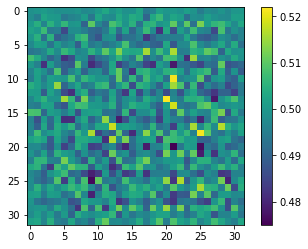

In [17]:
plt.imshow((generated_image[0, :, :, 0]+1)/2)
plt.colorbar()
plt.show()

### STEP 4. 판별자 모델 구현하기

(32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [18]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer  # 숫자 1개(진짜라고 판단되는 정도)
    model.add(layers.Dense(1))

    return model

In [19]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [20]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00254767]], dtype=float32)>

- 텐서플로우의 텐서 형태로 출력. 이 값 또한 아직은 아무런 의미가 없는 값.





#### 모델 학습

### STEP 5. 손실함수와 최적화 함수 구현하기

생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) 
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

 - 매번 학습 진행 확인 위해 생성자가 생성한 샘플을 확인.
 
 
 
 

- 샘플은 한 번에 16장을 생성. 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만듬.
  100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만듬.

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim]) # 고정된 seed 노이즈
seed.shape

TensorShape([16, 100])

### STEP 6. 훈련과정 상세 기능 구현하기

1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [39]:
def generate_and_save_images(model, epoch, it, sample_seeds, save_file_num=1):

    predictions = model(sample_seeds, training=False)  # 16개의 seed 가 들어있는 sample_seeds
    
    # [-1,1]로 정규화된 이미지를 원상복구함
    rescue_predictions = (predictions.numpy() * 127.5 + 127.5).astype(int)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  # 16개 sample 이라서 4행 4열로 시각화
        plt.imshow(rescue_predictions[i])  # plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)

    save_file_path = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/generated_samples/sample_{}'.format(save_file_num)
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    
    save_file_path = os.path.join(save_file_path, 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.savefig(save_file_path)  # 이미지 저장

    plt.show()

In [33]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch, save_file_num=1):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    save_file_path = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/training_history/train_history_{}'.format(save_file_num)
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    
    save_file_path = os.path.join(save_file_path, 'train_history_{:04d}.png'.format(epoch))
    plt.savefig(save_file_path)  # 이미지 저장

    plt.show()

In [34]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### STEP 7. 학습 과정 진행하기

위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.
(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [35]:
def train(dataset, epochs, save_every, save_file_num=1):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed, save_file_num)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint_dir = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/training_checkpoints/training_checkpoints_{}'.format(save_file_num)
            checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed, save_file_num)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch, save_file_num)

In [36]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

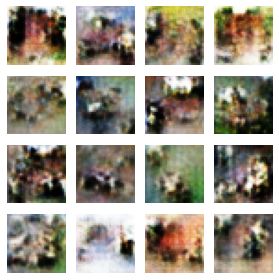

Time for training : 3347 sec


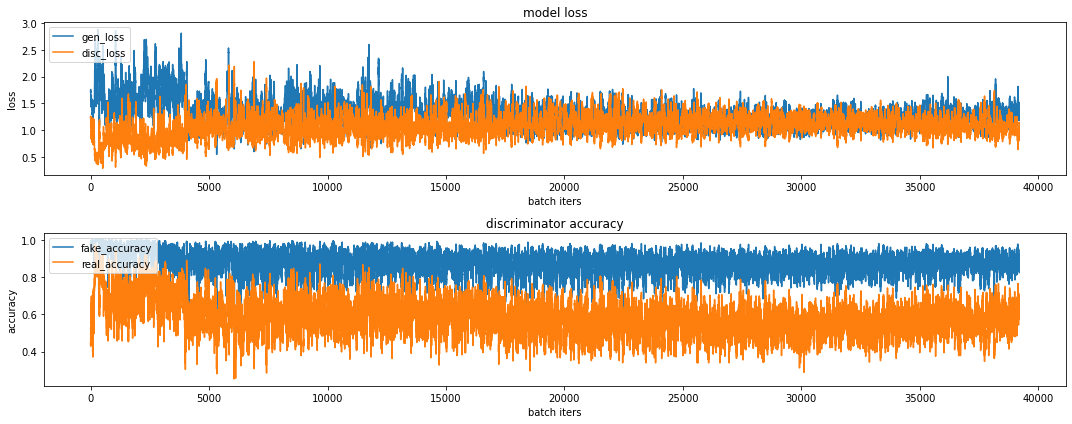

CPU times: user 58min 53s, sys: 7min 59s, total: 1h 6min 53s
Wall time: 55min 50s


In [37]:
%%time
train(train_dataset, EPOCHS, save_every, 1)

#### animate gif 생성

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples_2/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_0.gif

In [ ]:
# Fake Images to GIF
make_a_gif(1, True)

In [ ]:
# Fake Images to GIF
make_a_gif(1, True)

In [43]:
def draw_training_checkpoints_image(save_file_num=1):
    checkpoint_dir = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/training_checkpoints/training_checkpoints_{}'.format(save_file_num)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    checkpoint.restore(latest)

    generator = checkpoint.generator
    discriminator = checkpoint.discriminator

    # 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)
    plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

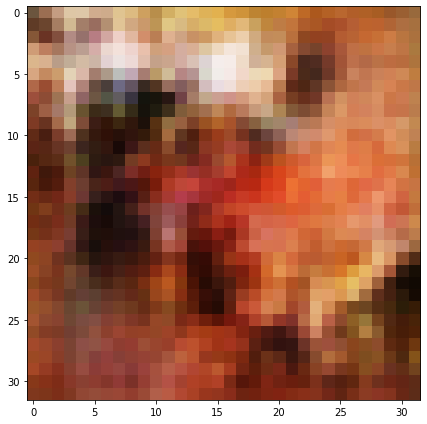

In [44]:
draw_training_checkpoints_image(1)

checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다.

%%time
train(train_dataset, EPOCHS, save_every)

### STEP 8. (optional) GAN 훈련 과정 개선하기

STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.
(참고) 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것입니다.

How to Train a GAN? Tips and tricks to make GANs work
10 Lessons I Learned Training GANs for one Year
Tips for Training Stable Generative Adversarial Networks
Improved Techniques for Training GANs(paper)


 #### GAN 훈련 과정 개선하기 
    
- Epoch을 200번 을 돌려서 제출기한까지 내는데도 시간이 빠듯해 개선점을 쓸만치 다양한 시도를 하지못했다    

### Reference


- https://eehoeskrap.tistory.com/430
  Batch Normalization 
  Normalization정규화 : 학습을 더 빨리 하기 위해서 or Local optimum 문제에 빠지는 가능성을 줄이기 위해서 사용.





- https://newly0513.tistory.com/20
  activation function 식 과 그래프
  
  
  

- https://mingrammer.com/underscore-in-python/#2-%EA%B0%92%EC%9D%84-%EB%AC%B4%EC%8B%9C%ED%95%98%EA%B3%A0-%EC%8B%B6%EC%9D%80-%EA%B2%BD%EC%9A%B0  파이썬 언더스코어(_) 




- https://schoolofweb.net/blog/posts/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%8D%B0%EC%BD%94%EB%A0%88%EC%9D%B4%ED%84%B0-decorator/
  python decorator,  @tf.function





- https://openai.com/research/generative-models   Generative Models - openai
  
  
  
  
- https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11  Transposed Convolutional Layer  





- https://schoolofweb.net/blog/posts/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%8D%B0%EC%BD%94%EB%A0%88%EC%9D%B4%ED%84%B0-decorator/
  python decorator,  @tf.function 역할

### 결론 및 회고 

- Epoch을 200을 돌려서는 fake accuray가 0.5를 향해 내려가질 않는걸 알았다.  Epoch을 2~3배 더 돌리면 0.5 근접하겠지만 제출시간에 맞추기 급급했다.


- DCGAN Generator model Conv2DTranspose layer Conv2D 와 반대로 image size 를 넓히는 층 (8,8,256) -> (16,16,64) -> (32,32,3)


##### [ 해결하지 못한 의문점들]

-  @tf.function로 코드  G-6-12 노드의 1번째, @tf.function 데코레이터가 적용된 2번째 실행결과 차이를 파악하다 말고 프로젝트 제츨 




- 노드하면서 찾아보고 확인 정리한게 많았지만 그외 해결하지 못한 내용이 많아 다시 볼게 많음.